In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

OPCODE_DATA_PATH = '../data/final_gas_schedule_comparison.csv'

df = pd.read_csv(OPCODE_DATA_PATH)
df = df.rename(columns=lambda x: x.replace('gas', 'us'))

In [2]:
df['max_us'] = df[['besu_us', 'erigon_us', 'geth_us', 'nethermind_us', 'revm_us']].max(axis=1)
opcode_df = df[['opcode','max_us', 'besu_us', 'erigon_us', 'geth_us', 'nethermind_us', 'revm_us']]

In [3]:
ecrecover_us = opcode_df[opcode_df['opcode'] == 'ECRECOVER']['max_us'].values[0]
keccak_us = opcode_df[opcode_df['opcode'] == 'KECCAK256']['max_us'].values[0]
extcodehash_us = opcode_df[opcode_df['opcode'] == 'EXTCODEHASH']['max_us'].values[0]
create_us = opcode_df[opcode_df['opcode'] == 'CREATE']['max_us'].values[0]

intrinsic_us = (
    1 * ecrecover_us +                 # Signature recovery
    12 * keccak_us +                   # Trie hashing
    1 * extcodehash_us +               # Best available proxy for account read
    0.5 * create_us                    # Scaled down CREATE as proxy for writes
)

gas_per_us = 21000/intrinsic_us

In [4]:
opcode_df = opcode_df.assign(
    precise_gas=opcode_df['max_us'] * gas_per_us,
    gas_ceil=lambda df: np.ceil(df['precise_gas']),
    rounding_error=lambda df: ((np.ceil(df['precise_gas']) - df['precise_gas']) / df['precise_gas'])
)

opcode_df[['opcode', 'precise_gas', 'gas_ceil', 'rounding_error']]

,opcode,precise_gas,gas_ceil,rounding_error
0,ADD,6.836966,7.0,0.023846
1,MUL,7.763890,8.0,0.030411
2,SUB,6.488973,7.0,0.078753
3,DIV,5.554878,6.0,0.080132
4,SDIV,8.995941,9.0,0.000451
...,...,...,...,...
162,CREATE_ARG2,0.483288,1.0,1.069158
163,RETURN_ARG1,0.002950,1.0,337.978270
164,REVERT_ARG1,0.004096,1.0,243.115909
165,RIPEMD-160_ARG1,1.605130,2.0,0.246005


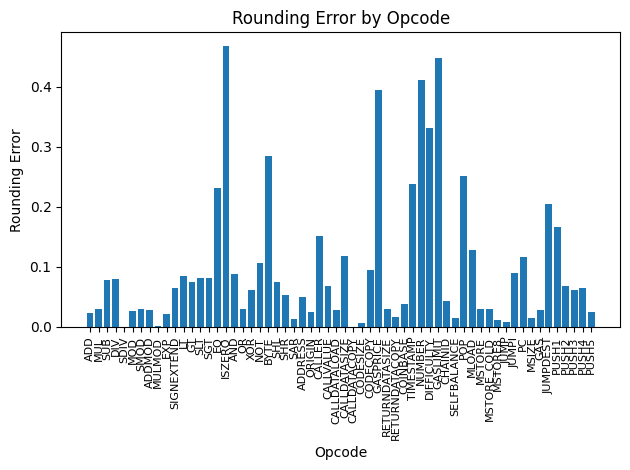

In [5]:
plt.bar(opcode_df['opcode'].head(60), opcode_df['rounding_error'].head(60))
plt.xlabel('Opcode')
plt.ylabel('Rounding Error')
plt.title('Rounding Error by Opcode')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()